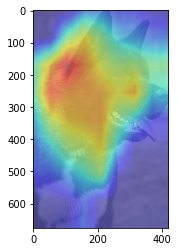

In [4]:
import numpy as np
import cv2
import matplotlib.pyplot as plt

from keras.models import Model

import keras.applications.inception_resnet_v2 as resnet_v2
from keras.layers import UpSampling2D, Conv2D


# Please set an appropriate image file
INPUT_IMG_FILE = "./dog-breeds/akita/10880.jpg"

################################################################
# The following parameters can be changed to other models
# that use global average pooling.
# e.g.) InceptionResnetV2 / NASNetLarge
NETWORK_INPUT_SIZE = 299
MODEL_CLASS = resnet_v2.InceptionResNetV2
PREPROCESS_FN = resnet_v2.preprocess_input
LAST_CONV_LAYER = "conv_7b_ac"
PRED_LAYER = "predictions"
################################################################

# number of imagenet classes
N_CLASSES = 1000


def load_img(fname, input_size, preprocess_fn):
    original_img = cv2.imread(fname)[:, :, ::-1]
    original_size = (original_img.shape[1], original_img.shape[0])
    img = cv2.resize(original_img, (input_size, input_size))
    imgs = np.expand_dims(preprocess_fn(img), axis=0)
    return imgs, original_img, original_size


def get_cam_model(model_class,
                  input_size=224,
                  last_conv_layer="activation_49",
                  pred_layer="fc1000"):
    model = model_class(input_shape=(input_size, input_size, 3), include_top=True)
#     model.summary()
    final_params = model.get_layer(pred_layer).get_weights()
    final_params = (final_params[0].reshape(
        1, 1, -1, N_CLASSES), final_params[1])

    last_conv_output = model.get_layer(last_conv_layer).output
    x = UpSampling2D(size=(32, 32), interpolation="bilinear")(
        last_conv_output)
    x = Conv2D(filters=N_CLASSES, kernel_size=(
        1, 1), name="predictions_2")(x)

    cam_model = Model(inputs=model.input,
                      outputs=[model.output, x])
    cam_model.get_layer("predictions_2").set_weights(final_params)
    return cam_model


def postprocess(preds, cams, top_k=1):
    idxes = np.argsort(preds[0])[-top_k:]
    class_activation_map = np.zeros_like(cams[0, :, :, 0])
    for i in idxes:
        class_activation_map += cams[0, :, :, i]
    return class_activation_map


# 1. load image
imgs, original_img, original_size = load_img(INPUT_IMG_FILE,
                                             input_size=NETWORK_INPUT_SIZE,
                                             preprocess_fn=resnet_v2.preprocess_input)

# 2. prediction
model = get_cam_model(MODEL_CLASS,
                      NETWORK_INPUT_SIZE,
                      LAST_CONV_LAYER,
                      PRED_LAYER)
preds, cams = model.predict(imgs)

# 4. post processing
class_activation_map = postprocess(preds, cams)

# 5. plot image+cam to original size
plt.imshow(original_img, alpha=0.5)
plt.imshow(cv2.resize(class_activation_map,
                      original_size), cmap='jet', alpha=0.5)
plt.show()